In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from PIL import Image
import json
import os
import torchvision
import torchvision.transforms as transforms
from math import ceil, floor
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchinfo import summary

# Config

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16
epochs = 10
lr = 0.001
split_size = 0.8

path_to_anns = "D:\\Studies\\ucenje\\keypoint_flickr\\data\\annotations\\all_data.json"
path_to_img = "D:\\Studies\\ucenje\\keypoint_flickr\\data\\images"

# Datasets and Dataloaders

In [3]:
class FlickrDatasetClassification(Dataset):
    def __init__(self, path_to_anns, path_to_imgs, transform=None):
        with open(path_to_anns, 'r') as f:
            self.anns = json.loads(f.read())
        self.image_path = path_to_imgs
        self.transform = transform

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_path, self.anns[str(idx)]["file_name"])
        image = Image.open(img_path).convert("RGB")
        orig_width, orig_height = image.size

        image.thumbnail((224, 224))
        image = np.array(image, dtype=np.uint8)
        keypoints = np.array(self.anns[str(idx)]["face_landmarks"], dtype=np.float32)
        keypoints = keypoints.clip(min=0, max=orig_height if orig_height >= orig_width else orig_width)
        keypoints = keypoints * [224.0 / orig_width, 224.0 / orig_height]
        keypoints = keypoints.astype('uint8')
        new_keypoints = torch.zeros(68, 224, 224)
        for i in range(len(new_keypoints)):
            new_keypoints[i][keypoints[i][0]-1][keypoints[i][1]-1] = 1
        if self.transform:
            image = self.transform(image)

        return image, new_keypoints, idx

dataset_classification = FlickrDatasetClassification(path_to_anns,path_to_img,
                        transform=transforms.ToTensor())
train_len = ceil(len(dataset_classification) * split_size)
val_len = ceil(len(dataset_classification) * (1-split_size))
train_dataset_classification, val_dataset_classification = torch.utils.data.random_split(dataset_classification, (train_len, val_len))
train_loader_classification = DataLoader(train_dataset_classification, batch_size=batch_size, shuffle=True)
val_loader_classification = DataLoader(val_dataset_classification, batch_size=1, shuffle=False)

# Utils

In [4]:
def plot_img_classification(predictions): # predictions list of tuple (index, predicted_keypoints)
    transform = transforms.ToPILImage() # transform tensor back to PILImage

    images, original_keypoints_list, predicted_keypoints_list = [], [], []

    for i, data in enumerate(predictions):
        image = dataset_classification[data[0].item()][0]
        image = transform(image.cpu().detach())  # Images to PIL, keypoints to numpy array
        images.append(image)
        original_keypoints = dataset_classification[data[0].item()][1]
        original_keypoints = original_keypoints.cpu().detach().numpy().reshape(-1, 2)
        original_keypoints_list.append(original_keypoints)
        predicted_keypoints = data[1].cpu().detach()
        predicted_keypoints = np.reshape(predicted_keypoints, (1,2,0))
        print(predicted_keypoints)
        for i in range(224):
            for j in range(224):
                index_of_keypoint = np.argmax(predicted_keypoints[i][j])
                max_of_keypoints = np.max(predicted_keypoints[i][j])
                if max_of_keypoints > .50:
                    predicted_keypoints_list.append((i, j))

    original_keypoints_list = np.array(original_keypoints_list)
    predicted_keypoints_list = np.array(predicted_keypoints_list)

    plt.figure(figsize=(40,80))
    for i in range(40):
        plt.subplot(20, 2, i + 1)
        plt.imshow(images[i // 2])
        if i % 2 == 0:
            for p in range(original_keypoints_list[i//2].shape[0]):
                plt.plot(original_keypoints_list[i//2][p, 0], original_keypoints_list[i//2][p, 1], 'g.')
        else:
            for p in range(predicted_keypoints_list[i//2].shape[0]):
                plt.plot(predicted_keypoints_list[i//2][p, 0], predicted_keypoints_list[i//2][p, 1], 'g.')
    print(predicted_keypoints_list[0])
    print(print(predictions[0][1]))
    plt.plot()

## Classification Model

In [5]:
class ClassificationCNN(nn.Module):
    def __init__(self):
        super(ClassificationCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 68, 5)
        self.batch1 = nn.BatchNorm2d(16)
        self.batch2 = nn.BatchNorm2d(32)
        self.batch3 = nn.BatchNorm2d(68)
        self.pool = nn.MaxPool2d(2,2)
        self.upsample1 = nn.Upsample(size=(50, 50), mode="bicubic")
        self.upsample2 = nn.Upsample(size=(110, 110), mode="bicubic")
        self.upsample3 = nn.Upsample(size=(224, 224), mode="bicubic")
    def forward(self, x):
        x = self.batch1(self.pool(F.relu(self.conv1(x))))
        x = self.batch2(self.pool(F.relu(self.conv2(x))))
        x = self.batch3(self.pool(F.relu(self.conv3(x))))
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)
        return x

# Training loop for regression

# Classification Model

In [6]:
class FlickrDatasetClassification(Dataset):
    def __init__(self, path_to_anns, path_to_imgs, transform=None):
        with open(path_to_anns, 'r') as f:
            self.anns = json.loads(f.read())
        self.image_path = path_to_imgs
        self.transform = transform

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_path, self.anns[str(idx)]["file_name"])
        image = Image.open(img_path).convert("RGB")
        orig_width, orig_height = image.size

        image.thumbnail((224, 224))
        image = np.array(image, dtype=np.uint8)
        keypoints = np.array(self.anns[str(idx)]["face_landmarks"], dtype=np.float32)
        keypoints = keypoints.clip(min=0, max=orig_height if orig_height >= orig_width else orig_width)
        keypoints = keypoints * [224.0 / orig_width, 224.0 / orig_height]
        keypoints = keypoints.astype('uint8')
        new_keypoints = torch.zeros(68, 224, 224)
        for i in range(len(new_keypoints)):
            new_keypoints[i][keypoints[i][0]-1][keypoints[i][1]-1] = 1
        if self.transform:
            image = self.transform(image)

        return image, new_keypoints, idx

dataset_classification = FlickrDatasetClassification(path_to_anns,path_to_img,
                                                     transform=transforms.ToTensor())
train_len = ceil(len(dataset_classification) * split_size)
val_len = ceil(len(dataset_classification) * (1-split_size))
train_dataset_classification, val_dataset_classification = torch.utils.data.random_split(dataset_classification, (train_len, val_len))
train_loader_classification = DataLoader(train_dataset_classification, batch_size=batch_size, shuffle=True)
val_loader_classification = DataLoader(val_dataset_classification, batch_size=1, shuffle=False)

In [7]:
model = ClassificationCNN().to(device)
summary(model, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ClassificationCNN                        [16, 68, 224, 224]        --
├─Conv2d: 1-1                            [16, 16, 222, 222]        448
├─MaxPool2d: 1-2                         [16, 16, 111, 111]        --
├─BatchNorm2d: 1-3                       [16, 16, 111, 111]        32
├─Conv2d: 1-4                            [16, 32, 109, 109]        4,640
├─MaxPool2d: 1-5                         [16, 32, 54, 54]          --
├─BatchNorm2d: 1-6                       [16, 32, 54, 54]          64
├─Conv2d: 1-7                            [16, 68, 50, 50]          54,468
├─MaxPool2d: 1-8                         [16, 68, 25, 25]          --
├─BatchNorm2d: 1-9                       [16, 68, 25, 25]          136
├─Upsample: 1-10                         [16, 68, 50, 50]          --
├─Upsample: 1-11                         [16, 68, 110, 110]        --
├─Upsample: 1-12                         [16, 68, 224, 224]        --
Total 

In [8]:
torch.cuda.empty_cache()
#model = ClassificationCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss = []

for epoch in range(epochs):
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader_classification), total=(len(train_loader_classification))):
        images, keypoints = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)
        preds = model(images)
        loss = criterion(preds, keypoints)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_running_loss += loss.item()
    train_loss.append(train_running_loss / (ceil(len(train_dataset_classification) / batch_size)))

    #model.eval()

    #with torch.no_grad():
    #    val_running_loss = 0.0
    #    for i, data in tqdm(enumerate(val_loader), total=(len(val_loader))):
    #        image, keypoints = data[0].to(device), data[1].to(device)
    #        preds = model(image)
    #        loss = criterion(preds, keypoints)
    #        val_running_loss += loss.item()
    #    val_loss.append(val_running_loss / ceil(len(val_dataset) / batch_size))
    print(f'Epoch: {epoch + 1}')
    print(f'Train_loss at epoch {epoch + 1}: {train_loss[-1]}')

100%|██████████| 250/250 [01:29<00:00,  2.79it/s]


Epoch: 1
Train_loss at epoch 1: 0.0042826280351728205


100%|██████████| 250/250 [01:30<00:00,  2.75it/s]


Epoch: 2
Train_loss at epoch 2: 0.003575248851440847


100%|██████████| 250/250 [01:31<00:00,  2.73it/s]


Epoch: 3
Train_loss at epoch 3: 0.0033735656328499316


100%|██████████| 250/250 [01:31<00:00,  2.73it/s]


Epoch: 4
Train_loss at epoch 4: 0.003272678516805172


100%|██████████| 250/250 [01:33<00:00,  2.67it/s]


Epoch: 5
Train_loss at epoch 5: 0.003195893209427595


100%|██████████| 250/250 [01:29<00:00,  2.78it/s]


Epoch: 6
Train_loss at epoch 6: 0.0031523521151393652


100%|██████████| 250/250 [01:28<00:00,  2.82it/s]


Epoch: 7
Train_loss at epoch 7: 0.003101418474689126


100%|██████████| 250/250 [01:30<00:00,  2.76it/s]


Epoch: 8
Train_loss at epoch 8: 0.0030718903969973324


100%|██████████| 250/250 [01:30<00:00,  2.77it/s]


Epoch: 9
Train_loss at epoch 9: 0.0030454199090600015


100%|██████████| 250/250 [01:32<00:00,  2.69it/s]

Epoch: 10
Train_loss at epoch 10: 0.003022938188165426


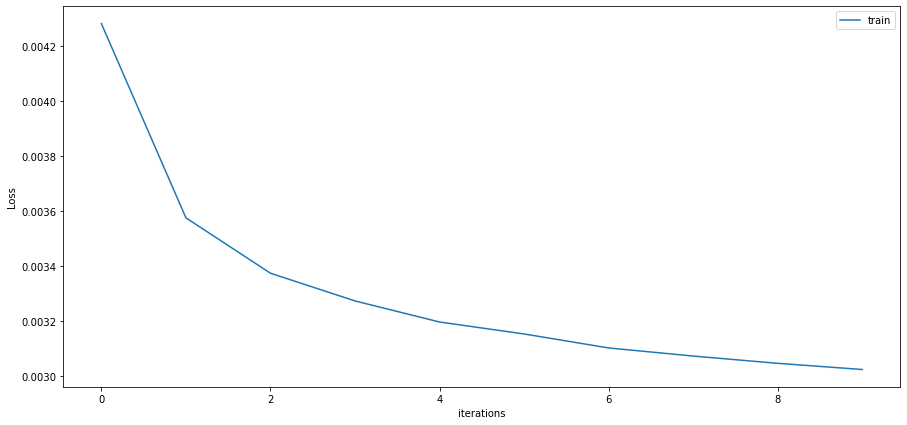

In [9]:
plt.figure(figsize=(15,7))
plt.plot(train_loss, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
model.eval()
predictions = []
soft = nn.Softmax(dim=1)
with torch.no_grad():
    for i, data in enumerate(val_loader_classification):
        images, keypoints, index = data[0].to(device), data[1].to(device), data[2]
        pred = soft(model(images))
        predictions.append((index, pred))

RuntimeError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 11.00 GiB total capacity; 10.26 GiB already allocated; 0 bytes free; 10.33 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
plot_img_classification(predictions)